In [6]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
from pentropy_main import *
import itertools
import json
import matplotlib.pyplot as plt
import copy
import random
import numpy as np
import time
from collections import defaultdict, Counter
print = print_

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


优化后的对称性化简办法 迭代版

In [7]:
# define parameters
N = 6
K = 4
point_num = 12 # 采样点密度
generate_size = 30
subset_size = 30
comb_size = 30
user_perm = list(itertools.permutations(range(1, K + 1)))
file_perm = list(itertools.permutations(range(1, N + 1)))
start_time = time.time()

In [8]:
# generate all random variables, stores in single_vars
single_vars = [] # 单变量=W+Z+reduced_X
Wrvs = [] # 原始W变量，也可以理解为一个全部W组成的单变量
W_combinations = [] # W变量组合之后的全部变量
Wrvs_cons = [] # 对前面的全部组合进行对称化去除之后的W_combinations
vars = [] # 用来在cutsetbound中使用的对象
necessary_vars = [] # 后面迭代的时候使用的。

for i in range(1, N+1):
    single_vars.append("W" + str(i))
    Wrvs.append("W" + str(i))
for i in range(1, K+1):
    single_vars.append("Z" + str(i))
vars.append(Wrvs)

X_combinations = ["X" + item for item in Iutils.generate_combinations(N, K)]
X_combinations = get_reduced_X_combination(N,K,False)

Xrvs_cons = Iutils.symmetry_vars(user_perm,file_perm,X_combinations)

for item in X_combinations:
    single_vars.append(item)
for var in single_vars:
    # vars.append([var])
    necessary_vars.append([var])
necessary_vars.append(Wrvs)
for r in range(N+1): # 这里似乎有点冗余，但是问题不大。
    # 生成指定长度的所有组合
    combos = itertools.combinations(Wrvs, r+1)
    for combo in combos:
        W_combinations.append(list(combo))
Wrvs_cons = Iutils.symmetry_vars(user_perm,file_perm,W_combinations)
print(Wrvs_cons)
print(single_vars)
Wkey = ','.join(sorted(Wrvs, key=Iutils.sort_key))
print(Wkey)
print(Xrvs_cons)

Wrvs_cons: ['W1', 'W1,W2', 'W1,W2,W3', 'W1,W2,W3,W4', 'W1,W2,W3,W4,W5', 'W1,W2,W3,W4,W5,W6']
single_vars: ['W1', 'W2', 'W3', 'W4', 'W5', 'W6', 'Z1', 'Z2', 'Z3', 'Z4', 'X1112', 'X1123', 'X1234']
Wkey: W1,W2,W3,W4,W5,W6
Xrvs_cons: ['X1112', 'X1123', 'X1234']


In [9]:
# regions,entropydict = create_cutset_bound(N,K,user_perm,file_perm,Wkey,vars)
# entropydict_all = copy.deepcopy(entropydict)

In [10]:
necessary_vars = [] # 单变量+W_all变量
vars = [] # 上面的necessary_vars+generated_sets，作为Z用于生成不等式；变量集合，元素为列表，一个列表对应一个联合熵，列表元素为字符串
entropydict = EntropyEqDict()
index = 0
episode = 0

for var in single_vars:
    vars.append([var])
    necessary_vars.append([var])
# necessary_vars = Iutils.symmetry_vars(N,K,vars)
necessary_vars.append(Wrvs)
vars.append(Wrvs)

sets = Iutils.generate_random_subsets(single_vars,subset_size,2,episode+4)
# print(sets)
vars += sets
print(necessary_vars)
print(vars)

necessary_vars: [['W1'], ['W2'], ['W3'], ['W4'], ['W5'], ['W6'], ['Z1'], ['Z2'], ['Z3'], ['Z4'], ['X1112'], ['X1123'], ['X1234'], ['W1', 'W2', 'W3', 'W4', 'W5', 'W6']]
vars: [['W1'], ['W2'], ['W3'], ['W4'], ['W5'], ['W6'], ['Z1'], ['Z2'], ['Z3'], ['Z4'], ['X1112'], ['X1123'], ['X1234'], ['W1', 'W2', 'W3', 'W4', 'W5', 'W6'], ['W1', 'W2', 'W4', 'X1234'], ['W2', 'W4', 'Z4'], ['W4', 'Z2', 'Z3'], ['W2', 'W3'], ['W1', 'Z2', 'Z4'], ['W2', 'W3'], ['W3', 'X1123', 'X1234'], ['W2', 'W4', 'Z1'], ['W3', 'Z2', 'X1234'], ['W5', 'X1123'], ['W5', 'Z1', 'X1234'], ['W1', 'W5', 'X1112'], ['W5', 'X1234'], ['W4', 'W6', 'Z1'], ['Z3', 'Z4', 'X1234'], ['W2', 'Z4', 'X1234'], ['W1', 'Z3', 'X1234'], ['W3', 'W4', 'W6'], ['W4', 'Z1', 'X1234'], ['Z1', 'Z3', 'X1123'], ['Z1', 'Z3', 'X1234'], ['W2', 'W6', 'Z2'], ['W1', 'Z1'], ['W4', 'X1123', 'X1234'], ['W3', 'Z2'], ['W3', 'Z2', 'Z3'], ['Z1', 'Z4', 'X1234'], ['W1', 'W2', 'X1112'], ['W1', 'W2', 'X1123'], ['Z1', 'X1112', 'X1123']]


In [11]:
expand_vars = vars[:]

combs,combinations = Iutils.generate_combs(single_vars,comb_size)
Iutils.preprocessing_combs(vars,single_vars,expand_vars,combs)    

entropydict = EntropyEqDict()
entropydict_all = EntropyEqDict()

print(len(expand_vars))
print(expand_vars)
Iutils.symmetrize_by_dict_simple(N,K,expand_vars,entropydict_all)
# Iutils.symmetrize_by_dict(user_perm,file_perm,expand_vars,entropydict,entropydict_all)
print(len(entropydict.redict))

Iutils.problem_constraints_process(N,K,Wkey,entropydict_all)
entropydict_all.regenerate_keys()

for var in expand_vars:
    var_str = ",".join(sorted(var,key=Iutils.sort_key))
    entropydict[var_str] = entropydict_all.get(var_str)
entropydict.regenerate_keys()

print(len(entropydict.redict))
print(entropydict.redict)

actual comb size(30)
1078
expand_vars: [['W1'], ['W2'], ['W3'], ['W4'], ['W5'], ['W6'], ['Z1'], ['Z2'], ['Z3'], ['Z4'], ['X1112'], ['X1123'], ['X1234'], ['W1', 'W2', 'W3', 'W4', 'W5', 'W6'], ['W1', 'W2', 'W4', 'X1234'], ['W2', 'W4', 'Z4'], ['W4', 'Z2', 'Z3'], ['W2', 'W3'], ['W1', 'Z2', 'Z4'], ['W2', 'W3'], ['W3', 'X1123', 'X1234'], ['W2', 'W4', 'Z1'], ['W3', 'Z2', 'X1234'], ['W5', 'X1123'], ['W5', 'Z1', 'X1234'], ['W1', 'W5', 'X1112'], ['W5', 'X1234'], ['W4', 'W6', 'Z1'], ['Z3', 'Z4', 'X1234'], ['W2', 'Z4', 'X1234'], ['W1', 'Z3', 'X1234'], ['W3', 'W4', 'W6'], ['W4', 'Z1', 'X1234'], ['Z1', 'Z3', 'X1123'], ['Z1', 'Z3', 'X1234'], ['W2', 'W6', 'Z2'], ['W1', 'Z1'], ['W4', 'X1123', 'X1234'], ['W3', 'Z2'], ['W3', 'Z2', 'Z3'], ['Z1', 'Z4', 'X1234'], ['W1', 'W2', 'X1112'], ['W1', 'W2', 'X1123'], ['Z1', 'X1112', 'X1123'], ['W1', 'Z4'], ['W1', 'Z1', 'Z4'], ['W1', 'Z2'], ['W1', 'W2'], ['W1', 'W5'], ['W1', 'W2', 'W5'], ['W1', 'X1234'], ['W1', 'Z4', 'X1234'], ['W1', 'W3'], ['W1', 'X1123'], ['W1', 'W

In [12]:
# generate inequalities
regions = Region.empty() # 这里是初始化为empty的region，后续更新为cutsetbound
Iutils.generate_inequalities_combs(vars,entropydict,regions,combinations) # 打印的是返回值Ixyz_list

[[Z1, Z4, ['W1']],
 [Z1, Z4],
 [Z1, Z4, ['Z2']],
 [Z1, Z4, ['X1112']],
 [Z1, Z4, ['X1123']],
 [Z1, Z4, ['X1234']],
 [Z1, Z4, ['W1', 'W2', 'W4', 'X1234']],
 [Z1, Z4, ['W2', 'W4', 'Z4']],
 [Z1, Z4, ['W4', 'Z2', 'Z3']],
 [Z1, Z4, ['W1', 'Z2', 'Z4']],
 [Z1, Z4, ['W3', 'X1123', 'X1234']],
 [Z1, Z4, ['W3', 'Z2', 'X1234']],
 [Z1, Z4, ['W5', 'X1123']],
 [Z1, Z4, ['W5', 'Z1', 'X1234']],
 [Z1, Z4, ['W1', 'W5', 'X1112']],
 [Z1, Z4, ['Z3', 'Z4', 'X1234']],
 [Z1, Z4, ['W2', 'Z4', 'X1234']],
 [Z1, Z4, ['W1', 'Z3', 'X1234']],
 [Z1, Z4, ['W3', 'W4', 'W6']],
 [Z1, Z4, ['W4', 'Z1', 'X1234']],
 [Z1, Z4, ['Z1', 'Z3', 'X1123']],
 [Z1, Z4, ['W2', 'W6', 'Z2']],
 [Z1, Z4, ['W4', 'X1123', 'X1234']],
 [Z1, Z4, ['W1', 'W2', 'X1112']],
 [Z1, Z4, ['W1', 'W2', 'X1123']],
 [Z1, Z4, ['Z1', 'X1112', 'X1123']],
 [Z2, Z4, ['W3', 'X1123', 'X1234']],
 [Z2, Z4, ['W5', 'Z1', 'X1234']],
 [Z2, Z4, ['W2', 'Z4', 'X1234']],
 [Z2, Z4, ['W4', 'Z1', 'X1234']],
 [Z2, Z4, ['Z1', 'Z3', 'X1123']],
 [Z2, Z4, ['Z1', 'Z3', 'X1234']],
 [Z2

In [13]:
print(len(regions.exprs))
for expr in regions.exprs:
    expr.sort_terms()
    print(expr)

571
expr: 2H({W1,Z1}) - H({W1}) - H({W1,Z1,Z2}) >= 0
expr: 2H({Z1}) - H({Z1,Z2}) >= 0
expr: 2H({Z1,Z2}) - H({Z1}) - H({Z1,Z2,Z3}) >= 0
expr: H({Z1,X1112}) + H({Z4,X1112}) - H({X1112}) - H({Z1,Z4,X1112}) >= 0
expr: H({Z1,X1123}) + H({Z3,X1123}) - H({X1123}) - H({Z1,Z3,X1123}) >= 0
expr: 2H({Z1,X1234}) - H({X1234}) - H({Z1,Z2,X1234}) >= 0
expr: 2H({W1,W2,Z3,X1234}) - H({W1,W2,W3,X1234}) - H({W1,Z2,Z3,X1234}) >= 0
expr: 2H({W1,W2,Z1}) - H({W1,W2}) - H({W1,W2,Z2,Z4}) >= 0
expr: 2H({W1,Z1,Z2,Z4}) - H({W1,Z1,Z2}) - H({W3,Z1,Z2,Z3,Z4}) >= 0
expr: 2H({W1,Z1,Z2}) - H({W1,Z1}) - H({W1,Z1,Z2,Z4}) >= 0
expr: H({Z4,X1123,X1234}) + H({W3,Z1,X1123,X1234}) - H({W3,X1123,X1234}) - H({Z1,Z4,X1123,X1234}) >= 0
expr: 2H({W1,Z2,Z3,X1234}) - H({W1,Z2,X1234}) - H({W1,Z2,Z3,Z4,X1234}) >= 0
expr: H({W4,Z1,X1123}) + H({W4,Z3,X1123}) - H({W4,X1123}) - H({W4,Z1,Z3,X1123}) >= 0
expr: 2H({W5,Z1,X1234}) - H({W5,X1234}) - H({W5,Z1,Z2,X1234}) >= 0
expr: H({W3,Z1,X1112}) + H({W1,W5,Z4,X1112}) - H({W1,W3,X1112}) - H({W3

In [14]:
# construct the constranits matrix
ent_num = len(entropydict.redict) + 3
ine_constraints = Regions2Matrix(entropydict,regions)

306


In [15]:
# problem constraints
ine_constraints,prob_cons_num = AddProblemConstrains2Matrix(Xrvs_cons,Wrvs_cons,entropydict,ent_num,ine_constraints)


['X1112', 'X1123', 'X1234']
['W1', 'W1,W2', 'W1,W2,W3', 'W1,W2,W3,W4', 'W1,W2,W3,W4,W5', 'W1,W2,W3,W4,W5,W6']


In [16]:
ine_constraints = np.array(ine_constraints)
print(ine_constraints.shape)
ine_constraints = ine_constraints.astype(np.float64)
expr_num = ine_constraints.shape[0] - 1 # 不等式数量
ent_num = ine_constraints.shape[1] - 1 # 减之前用于生成矩阵，减之后就是实际的熵变量数量

ori_obj_coef = np.zeros(ent_num)
ori_obj_coef[-1] = 1 # M，R，F
print(ent_num)

(582, 309)
ent_num: 308


In [17]:
# solve problem
plot_data = [] # (M_value,optimal_value)
effective_idx_gurobi = [] # index from gurobi
all_eff_indx = set() # 缩减之后的有效索引
result_slope = []# 
ori_slope = []
M_space = np.linspace(0,N,point_num*N+1)
dual_value = [] # 每个M下的对偶变量的值
effective_idx_cut = [] # 缩减之后的有效索引
# print(M_space)
for M_value in M_space:
    # 根据M_value更新约束矩阵，添加等式约束
    ine_constraints = list(ine_constraints[:-1])
    row = [0] * (ent_num + 1)
    row[-3] = 1
    row[-1] = M_value
    ine_constraints.append(row)
    ine_constraints = np.array(ine_constraints)
    
    # print("ine_constraints")
    # print(ine_constraints)
    # print("ori_obj_coef",ori_obj_coef)

    # # 更新对偶问题约束矩阵
    expr_num = ine_constraints.shape[0] - 1
    trans_ine_cons = ine_constraints.T[:-1] # 对偶问题的约束矩阵 是原约束矩阵的转置
    dual_obj_coef = ine_constraints[:,-1] # 原约束的常量 是对偶问题目标函数的系数
    trans_ine_cons = np.hstack((trans_ine_cons, ori_obj_coef.T.reshape(-1, 1))) # 原目标函数的系数，是对偶问题约束的常量
    # print("shape",trans_ine_cons.shape)
    # print("trans_ine_cons")
    # print(trans_ine_cons)
    # print("dual_obj_coef",dual_obj_coef)

    # 求解原LP问题
    result,effective_idx_gurobi = gurobi_solver(effective_idx_gurobi,ori_obj_coef,ent_num,ine_constraints,regions)
    if type(result) == list:
        bad = Region.empty()
        for ine in result:
            idx = int(ine[1:])
            print(f"type:{type(idx)},value:{idx}")
            terms = []
            row = ine_constraints[idx]
            for i in range(len(row) - 1):
                coef = row[i]
                if coef != 0:
                    if entropydict.get_keys_by_value(i) != None:
                        term_x = entropydict.get_keys_by_value(i)[0]
                        var_str = term_x.split(",")
                        if var_str not in vars:
                            vars.append(var_str) # 添加有效不等式中的变量
                        term_x = Comp.jes(term_x)
                        term = Term(x=[term_x.copy()],coef=int(coef),termtype=TermType.H)
                        terms.append(term) 
            expr = Expr(terms, eqtype="ge", value=row[-1])
            expr.sort_terms()
            # print("expr",expr)
            bad.append_expr(expr)
        for expr in bad.exprs:
            print(expr)
   
    # 求解对偶LP问题
    if result != 0:
        solution_values, effective_idx_dual = dual_solver(expr_num,dual_obj_coef,trans_ine_cons,prob_cons_num)
        if solution_values is not None:
            dual_value.append(list(solution_values.values()))

        # print("effective_indices",effective_idx_dual)
        if effective_idx_dual is not None:
            all_eff_indx = all_eff_indx.union(set(effective_idx_dual))
        effective_idx_dual = sorted(list(all_eff_indx))
    
    plot_data.append((M_value, result))
if len(dual_value) > 0:
    effective_idx_cut = find_min_effective_indices(dual_value,regions)
    # print("dual")
    # print(dual_value)
    print(f"dual:{len(effective_idx_dual)}")
    print(effective_idx_dual)
    print(f"gurobi:{len(effective_idx_gurobi)}")
    print(effective_idx_gurobi)
    print(f"cut:{len(effective_idx_cut)}")
    print(effective_idx_cut)

Set parameter Username
Set parameter LicenseID to value 2626985
Academic license - for non-commercial use only - expires 2026-02-24
Optimal value: 0.5
Model status: 4
Optimal value: 0.4305555555555555
Model status: 4
Optimal value: 0.36111111111111116
Model status: 4
Optimal value: 0.29166666666666674
Model status: 4
Optimal value: 0.2222222222222222
Model status: 4
Optimal value: 0.16666666666666674
Model status: 4
Optimal value: 0.11111111111111108
Model status: 4
Optimal value: 0.05555555555555558
Model status: 4
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Opt

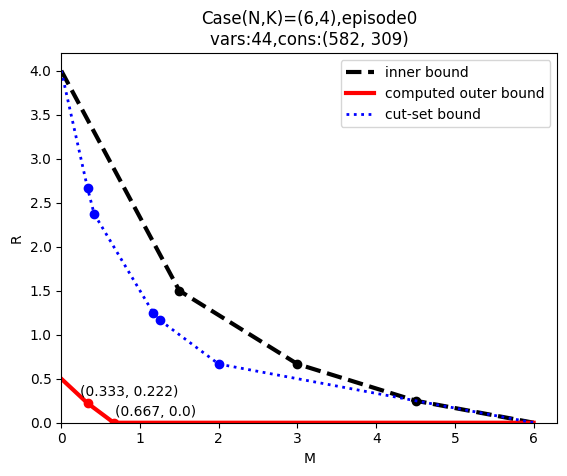

from start to now:  25.945311307907104 s


In [18]:
# plot

Iutils.plot_inner_bound(N,K)
# plot the calculation result
x = [item[0] for item in plot_data]
y = [item[1] for item in plot_data]
result_slope = Iutils.compute_slopes(x,y)
point_x = []
point_y = []
for i in range(1,len(result_slope)):
    if result_slope[i-1] != result_slope[i]:
        point_x.append(x[i])
        point_y.append(y[i])
plt.scatter(point_x,point_y,color='red')

for xi, yi in zip(point_x, point_y):
    label = f"({round(xi,3)}, {round(yi,3)})"
    plt.annotate(label,  
                (xi, yi),  
                textcoords="offset points",  
                xytext=(30, 5),  
                ha='center') 
plt.plot(x, y, color='red', linewidth=3, label='computed outer bound')
Iutils.plot_cutset_bound(N,K,point_num)

plt.xlim(left=0)
plt.ylim(bottom=0)
plt.xlabel("M")
plt.ylabel("R")
plt.legend()
plt.title(f"Case(N,K)=({N},{K}),episode0\nvars:{len(vars)},cons:{ine_constraints.shape}")
plt.show()
print("from start to now: ",time.time()-start_time,"s")

actual comb size(30)
get:593,time:0
not get:761,time:5.381919200019183
366
['X1112', 'X1123', 'X1234']
['W1', 'W1,W2', 'W1,W2,W3', 'W1,W2,W3,W4', 'W1,W2,W3,W4,W5', 'W1,W2,W3,W4,W5,W6']
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.0
Optimal value: 0.

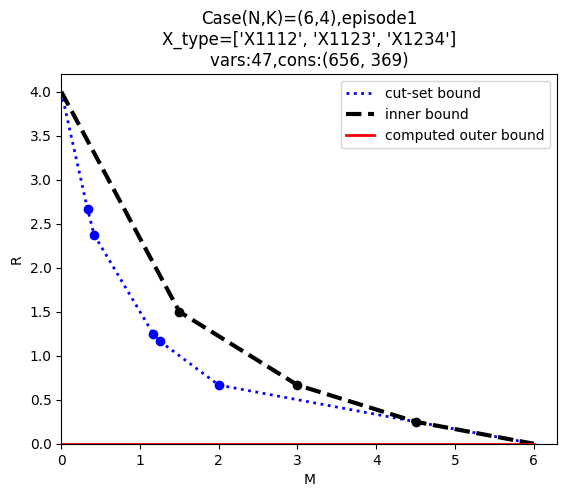

from start to now:  44.145702600479126 s
x: [0.0, 0.08333333333333333, 0.16666666666666666, 0.25, 0.3333333333333333, 0.41666666666666663, 0.5, 0.5833333333333333, 0.6666666666666666, 0.75, 0.8333333333333333, 0.9166666666666666, 1.0, 1.0833333333333333, 1.1666666666666665, 1.25, 1.3333333333333333, 1.4166666666666665, 1.5, 1.5833333333333333, 1.6666666666666665, 1.75, 1.8333333333333333, 1.9166666666666665, 2.0, 2.083333333333333, 2.1666666666666665, 2.25, 2.333333333333333, 2.4166666666666665, 2.5, 2.583333333333333, 2.6666666666666665, 2.75, 2.833333333333333, 2.9166666666666665, 3.0, 3.083333333333333, 3.1666666666666665, 3.25, 3.333333333333333, 3.4166666666666665, 3.5, 3.583333333333333, 3.6666666666666665, 3.75, 3.833333333333333, 3.9166666666666665, 4.0, 4.083333333333333, 4.166666666666666, 4.25, 4.333333333333333, 4.416666666666666, 4.5, 4.583333333333333, 4.666666666666666, 4.75, 4.833333333333333, 4.916666666666666, 5.0, 5.083333333333333, 5.166666666666666, 5.25, 5.3333333

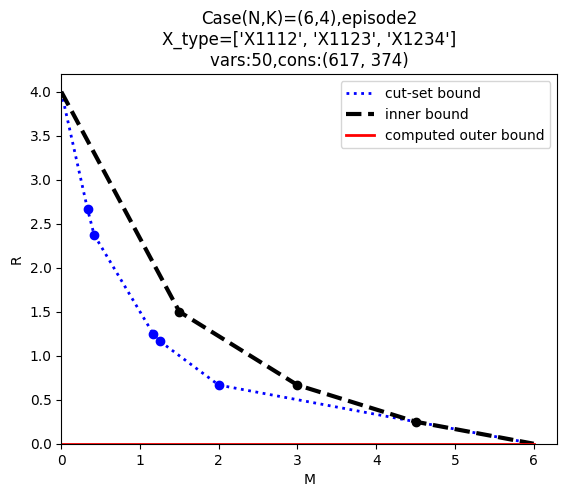

from start to now:  63.11666917800903 s
x: [0.0, 0.08333333333333333, 0.16666666666666666, 0.25, 0.3333333333333333, 0.41666666666666663, 0.5, 0.5833333333333333, 0.6666666666666666, 0.75, 0.8333333333333333, 0.9166666666666666, 1.0, 1.0833333333333333, 1.1666666666666665, 1.25, 1.3333333333333333, 1.4166666666666665, 1.5, 1.5833333333333333, 1.6666666666666665, 1.75, 1.8333333333333333, 1.9166666666666665, 2.0, 2.083333333333333, 2.1666666666666665, 2.25, 2.333333333333333, 2.4166666666666665, 2.5, 2.583333333333333, 2.6666666666666665, 2.75, 2.833333333333333, 2.9166666666666665, 3.0, 3.083333333333333, 3.1666666666666665, 3.25, 3.333333333333333, 3.4166666666666665, 3.5, 3.583333333333333, 3.6666666666666665, 3.75, 3.833333333333333, 3.9166666666666665, 4.0, 4.083333333333333, 4.166666666666666, 4.25, 4.333333333333333, 4.416666666666666, 4.5, 4.583333333333333, 4.666666666666666, 4.75, 4.833333333333333, 4.916666666666666, 5.0, 5.083333333333333, 5.166666666666666, 5.25, 5.33333333

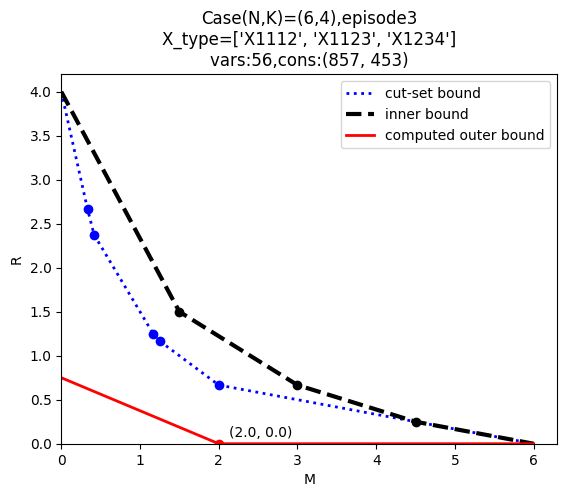

from start to now:  91.61499500274658 s
x: [0.0, 0.08333333333333333, 0.16666666666666666, 0.25, 0.3333333333333333, 0.41666666666666663, 0.5, 0.5833333333333333, 0.6666666666666666, 0.75, 0.8333333333333333, 0.9166666666666666, 1.0, 1.0833333333333333, 1.1666666666666665, 1.25, 1.3333333333333333, 1.4166666666666665, 1.5, 1.5833333333333333, 1.6666666666666665, 1.75, 1.8333333333333333, 1.9166666666666665, 2.0, 2.083333333333333, 2.1666666666666665, 2.25, 2.333333333333333, 2.4166666666666665, 2.5, 2.583333333333333, 2.6666666666666665, 2.75, 2.833333333333333, 2.9166666666666665, 3.0, 3.083333333333333, 3.1666666666666665, 3.25, 3.333333333333333, 3.4166666666666665, 3.5, 3.583333333333333, 3.6666666666666665, 3.75, 3.833333333333333, 3.9166666666666665, 4.0, 4.083333333333333, 4.166666666666666, 4.25, 4.333333333333333, 4.416666666666666, 4.5, 4.583333333333333, 4.666666666666666, 4.75, 4.833333333333333, 4.916666666666666, 5.0, 5.083333333333333, 5.166666666666666, 5.25, 5.33333333

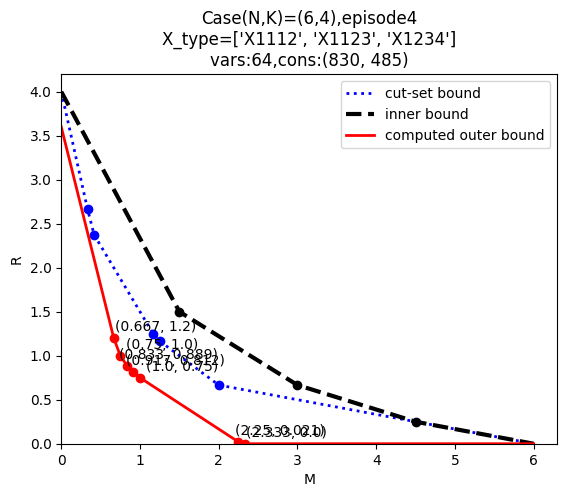

from start to now:  122.98693108558655 s
x: [0.0, 0.08333333333333333, 0.16666666666666666, 0.25, 0.3333333333333333, 0.41666666666666663, 0.5, 0.5833333333333333, 0.6666666666666666, 0.75, 0.8333333333333333, 0.9166666666666666, 1.0, 1.0833333333333333, 1.1666666666666665, 1.25, 1.3333333333333333, 1.4166666666666665, 1.5, 1.5833333333333333, 1.6666666666666665, 1.75, 1.8333333333333333, 1.9166666666666665, 2.0, 2.083333333333333, 2.1666666666666665, 2.25, 2.333333333333333, 2.4166666666666665, 2.5, 2.583333333333333, 2.6666666666666665, 2.75, 2.833333333333333, 2.9166666666666665, 3.0, 3.083333333333333, 3.1666666666666665, 3.25, 3.333333333333333, 3.4166666666666665, 3.5, 3.583333333333333, 3.6666666666666665, 3.75, 3.833333333333333, 3.9166666666666665, 4.0, 4.083333333333333, 4.166666666666666, 4.25, 4.333333333333333, 4.416666666666666, 4.5, 4.583333333333333, 4.666666666666666, 4.75, 4.833333333333333, 4.916666666666666, 5.0, 5.083333333333333, 5.166666666666666, 5.25, 5.3333333

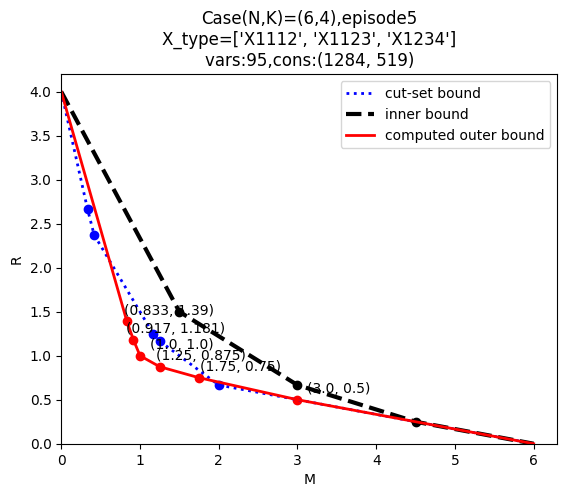

from start to now:  188.46997141838074 s
x: [0.0, 0.08333333333333333, 0.16666666666666666, 0.25, 0.3333333333333333, 0.41666666666666663, 0.5, 0.5833333333333333, 0.6666666666666666, 0.75, 0.8333333333333333, 0.9166666666666666, 1.0, 1.0833333333333333, 1.1666666666666665, 1.25, 1.3333333333333333, 1.4166666666666665, 1.5, 1.5833333333333333, 1.6666666666666665, 1.75, 1.8333333333333333, 1.9166666666666665, 2.0, 2.083333333333333, 2.1666666666666665, 2.25, 2.333333333333333, 2.4166666666666665, 2.5, 2.583333333333333, 2.6666666666666665, 2.75, 2.833333333333333, 2.9166666666666665, 3.0, 3.083333333333333, 3.1666666666666665, 3.25, 3.333333333333333, 3.4166666666666665, 3.5, 3.583333333333333, 3.6666666666666665, 3.75, 3.833333333333333, 3.9166666666666665, 4.0, 4.083333333333333, 4.166666666666666, 4.25, 4.333333333333333, 4.416666666666666, 4.5, 4.583333333333333, 4.666666666666666, 4.75, 4.833333333333333, 4.916666666666666, 5.0, 5.083333333333333, 5.166666666666666, 5.25, 5.3333333

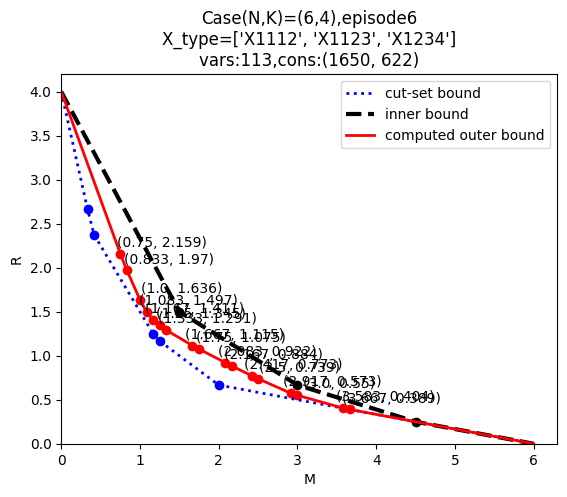

from start to now:  283.94820499420166 s
x: [0.0, 0.08333333333333333, 0.16666666666666666, 0.25, 0.3333333333333333, 0.41666666666666663, 0.5, 0.5833333333333333, 0.6666666666666666, 0.75, 0.8333333333333333, 0.9166666666666666, 1.0, 1.0833333333333333, 1.1666666666666665, 1.25, 1.3333333333333333, 1.4166666666666665, 1.5, 1.5833333333333333, 1.6666666666666665, 1.75, 1.8333333333333333, 1.9166666666666665, 2.0, 2.083333333333333, 2.1666666666666665, 2.25, 2.333333333333333, 2.4166666666666665, 2.5, 2.583333333333333, 2.6666666666666665, 2.75, 2.833333333333333, 2.9166666666666665, 3.0, 3.083333333333333, 3.1666666666666665, 3.25, 3.333333333333333, 3.4166666666666665, 3.5, 3.583333333333333, 3.6666666666666665, 3.75, 3.833333333333333, 3.9166666666666665, 4.0, 4.083333333333333, 4.166666666666666, 4.25, 4.333333333333333, 4.416666666666666, 4.5, 4.583333333333333, 4.666666666666666, 4.75, 4.833333333333333, 4.916666666666666, 5.0, 5.083333333333333, 5.166666666666666, 5.25, 5.3333333

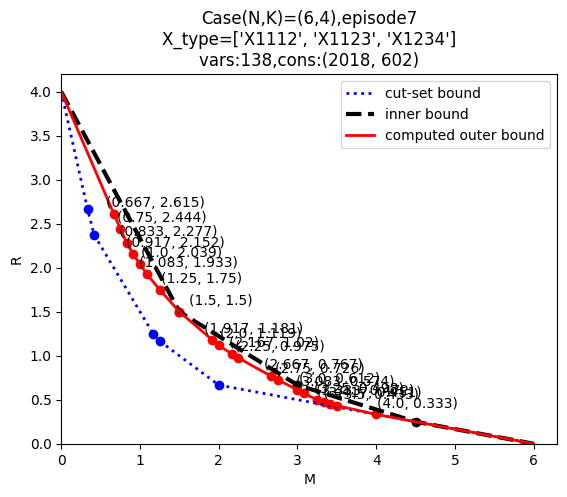

from start to now:  398.6189544200897 s
x: [0.0, 0.08333333333333333, 0.16666666666666666, 0.25, 0.3333333333333333, 0.41666666666666663, 0.5, 0.5833333333333333, 0.6666666666666666, 0.75, 0.8333333333333333, 0.9166666666666666, 1.0, 1.0833333333333333, 1.1666666666666665, 1.25, 1.3333333333333333, 1.4166666666666665, 1.5, 1.5833333333333333, 1.6666666666666665, 1.75, 1.8333333333333333, 1.9166666666666665, 2.0, 2.083333333333333, 2.1666666666666665, 2.25, 2.333333333333333, 2.4166666666666665, 2.5, 2.583333333333333, 2.6666666666666665, 2.75, 2.833333333333333, 2.9166666666666665, 3.0, 3.083333333333333, 3.1666666666666665, 3.25, 3.333333333333333, 3.4166666666666665, 3.5, 3.583333333333333, 3.6666666666666665, 3.75, 3.833333333333333, 3.9166666666666665, 4.0, 4.083333333333333, 4.166666666666666, 4.25, 4.333333333333333, 4.416666666666666, 4.5, 4.583333333333333, 4.666666666666666, 4.75, 4.833333333333333, 4.916666666666666, 5.0, 5.083333333333333, 5.166666666666666, 5.25, 5.33333333

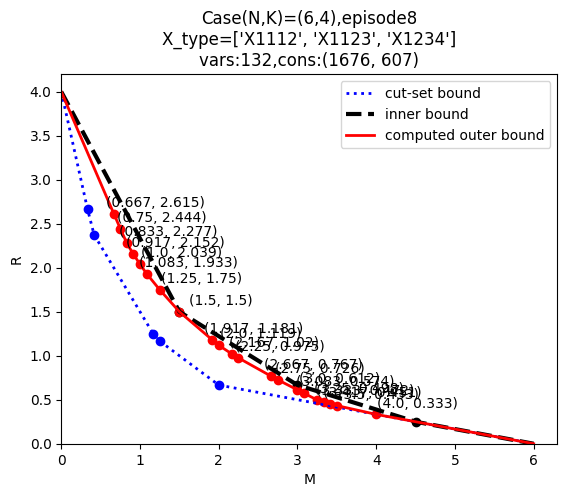

from start to now:  485.57459831237793 s
x: [0.0, 0.08333333333333333, 0.16666666666666666, 0.25, 0.3333333333333333, 0.41666666666666663, 0.5, 0.5833333333333333, 0.6666666666666666, 0.75, 0.8333333333333333, 0.9166666666666666, 1.0, 1.0833333333333333, 1.1666666666666665, 1.25, 1.3333333333333333, 1.4166666666666665, 1.5, 1.5833333333333333, 1.6666666666666665, 1.75, 1.8333333333333333, 1.9166666666666665, 2.0, 2.083333333333333, 2.1666666666666665, 2.25, 2.333333333333333, 2.4166666666666665, 2.5, 2.583333333333333, 2.6666666666666665, 2.75, 2.833333333333333, 2.9166666666666665, 3.0, 3.083333333333333, 3.1666666666666665, 3.25, 3.333333333333333, 3.4166666666666665, 3.5, 3.583333333333333, 3.6666666666666665, 3.75, 3.833333333333333, 3.9166666666666665, 4.0, 4.083333333333333, 4.166666666666666, 4.25, 4.333333333333333, 4.416666666666666, 4.5, 4.583333333333333, 4.666666666666666, 4.75, 4.833333333333333, 4.916666666666666, 5.0, 5.083333333333333, 5.166666666666666, 5.25, 5.3333333

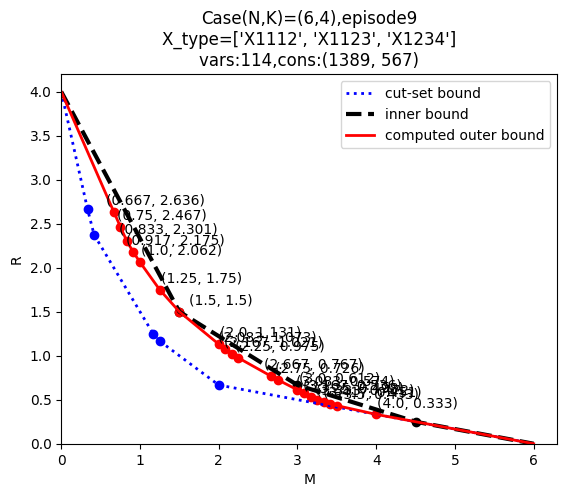

from start to now:  554.5777781009674 s
x: [0.0, 0.08333333333333333, 0.16666666666666666, 0.25, 0.3333333333333333, 0.41666666666666663, 0.5, 0.5833333333333333, 0.6666666666666666, 0.75, 0.8333333333333333, 0.9166666666666666, 1.0, 1.0833333333333333, 1.1666666666666665, 1.25, 1.3333333333333333, 1.4166666666666665, 1.5, 1.5833333333333333, 1.6666666666666665, 1.75, 1.8333333333333333, 1.9166666666666665, 2.0, 2.083333333333333, 2.1666666666666665, 2.25, 2.333333333333333, 2.4166666666666665, 2.5, 2.583333333333333, 2.6666666666666665, 2.75, 2.833333333333333, 2.9166666666666665, 3.0, 3.083333333333333, 3.1666666666666665, 3.25, 3.333333333333333, 3.4166666666666665, 3.5, 3.583333333333333, 3.6666666666666665, 3.75, 3.833333333333333, 3.9166666666666665, 4.0, 4.083333333333333, 4.166666666666666, 4.25, 4.333333333333333, 4.416666666666666, 4.5, 4.583333333333333, 4.666666666666666, 4.75, 4.833333333333333, 4.916666666666666, 5.0, 5.083333333333333, 5.166666666666666, 5.25, 5.33333333

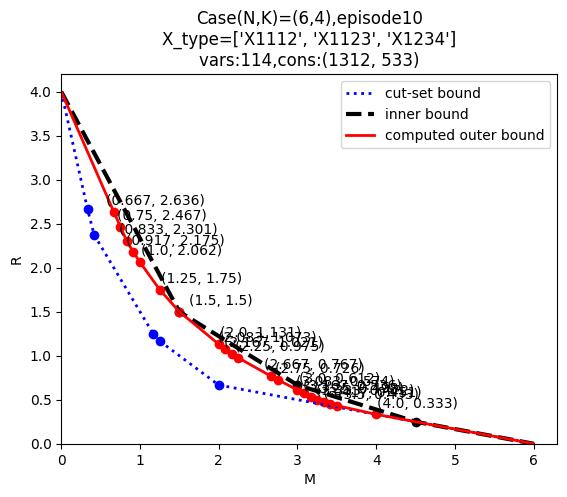

from start to now:  617.0563666820526 s
x: [0.0, 0.08333333333333333, 0.16666666666666666, 0.25, 0.3333333333333333, 0.41666666666666663, 0.5, 0.5833333333333333, 0.6666666666666666, 0.75, 0.8333333333333333, 0.9166666666666666, 1.0, 1.0833333333333333, 1.1666666666666665, 1.25, 1.3333333333333333, 1.4166666666666665, 1.5, 1.5833333333333333, 1.6666666666666665, 1.75, 1.8333333333333333, 1.9166666666666665, 2.0, 2.083333333333333, 2.1666666666666665, 2.25, 2.333333333333333, 2.4166666666666665, 2.5, 2.583333333333333, 2.6666666666666665, 2.75, 2.833333333333333, 2.9166666666666665, 3.0, 3.083333333333333, 3.1666666666666665, 3.25, 3.333333333333333, 3.4166666666666665, 3.5, 3.583333333333333, 3.6666666666666665, 3.75, 3.833333333333333, 3.9166666666666665, 4.0, 4.083333333333333, 4.166666666666666, 4.25, 4.333333333333333, 4.416666666666666, 4.5, 4.583333333333333, 4.666666666666666, 4.75, 4.833333333333333, 4.916666666666666, 5.0, 5.083333333333333, 5.166666666666666, 5.25, 5.33333333

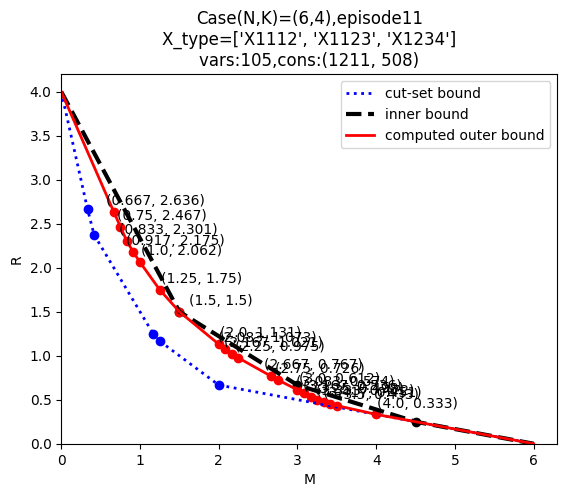

from start to now:  674.7453305721283 s
x: [0.0, 0.08333333333333333, 0.16666666666666666, 0.25, 0.3333333333333333, 0.41666666666666663, 0.5, 0.5833333333333333, 0.6666666666666666, 0.75, 0.8333333333333333, 0.9166666666666666, 1.0, 1.0833333333333333, 1.1666666666666665, 1.25, 1.3333333333333333, 1.4166666666666665, 1.5, 1.5833333333333333, 1.6666666666666665, 1.75, 1.8333333333333333, 1.9166666666666665, 2.0, 2.083333333333333, 2.1666666666666665, 2.25, 2.333333333333333, 2.4166666666666665, 2.5, 2.583333333333333, 2.6666666666666665, 2.75, 2.833333333333333, 2.9166666666666665, 3.0, 3.083333333333333, 3.1666666666666665, 3.25, 3.333333333333333, 3.4166666666666665, 3.5, 3.583333333333333, 3.6666666666666665, 3.75, 3.833333333333333, 3.9166666666666665, 4.0, 4.083333333333333, 4.166666666666666, 4.25, 4.333333333333333, 4.416666666666666, 4.5, 4.583333333333333, 4.666666666666666, 4.75, 4.833333333333333, 4.916666666666666, 5.0, 5.083333333333333, 5.166666666666666, 5.25, 5.33333333

KeyboardInterrupt: 

In [19]:
episode = 0
oriall_vars = [] # 存放所有已经生成过的变量
same_times = 0
stop_same_time = 5
effctive_vars_last = []
while episode < 500:
    episode += 1
    # print("episode",episode)
    # print(ori_slope)
    # print(result_slope)
    if ori_slope ==  result_slope:
        same_times += 1
    else:
        same_times = 0
    if same_times == stop_same_time:
        break
    # print("oriall vars",len(oriall_vars))
    # print("same times",same_times)
    # print(entropydict_all.eqdict)
    # 更新regions、vars
    # print("1.更新regions、vars")
    # print("number of effective exprs:",len(effective_idx_cut))
    # print(effective_indices)
    effective_constraints = [ine_constraints[i] for i in effective_idx_cut]
    regions = Region.empty() # 更新regions
    ori_vars = vars[:]
    oriall_vars += vars[:]
    # entropydict_all = entropydict.copy()
    vars = []
    effective_vars = []
    effective_idx_cut = []
    add_vars = set()
    del_vars = set()
    index = 0
    count_dict = {}
    # regions = cutset_regions.copy()
    # print("dict",regions.exprdict)
    for row in effective_constraints:
        terms = []
        term_list = []
        for i in range(len(row) - 1):
            coef = row[i]
            if coef != 0:
                if entropydict.get_keys_by_value(i) != None:
                    term_x = entropydict.get_keys_by_value(i)[0]
                    var_str = term_x.split(",")
                    if term_x in count_dict:
                        count_dict[term_x] += 1
                    else:
                        count_dict[term_x] = 1
                    if var_str not in vars:
                        vars.append(var_str) # 添加有效不等式中的变量
                    term_list.append(coef)
                    term_list.append(term_x)
                    term_x = Comp.jes(term_x)
                    term = Term(x=[term_x.copy()],coef=int(coef),termtype=TermType.H)
                    terms.append(term)
        # print(term_list)
        # x_vars, y_vars, z_vars = extract_single_var_conditional(term_list)
        # print(f"x_vars:{x_vars}, y_vars:{y_vars}, z_vars:{z_vars}")
        expr = Expr(terms, eqtype="ge", value=row[-1])
        expr.sort_terms()
        # print("expr",expr)
        regions.append_expr(expr)
    for expr in regions.exprs:
        pass
        # print(expr)
        
       
    effective_vars = vars[:]
    add_vars = set(map(tuple, effective_vars)) - set(map(tuple, effctive_vars_last))
    del_vars = set(map(tuple, effctive_vars_last)) - set(map(tuple, effective_vars))
    effctive_vars_last = vars[:]
    
    # print(f"add vars:{add_vars}")
    # print(f"del vars:{del_vars}")

    # print("effective vars",vars)
    # print("len of effecitve vars",len(vars))
    count_dict = sorted(count_dict.items(), key=lambda item: item[1],reverse=True)
    count_dict = dict(count_dict)
    # print(count_dict)

    # 生成新vars
    # print("2.生成新vars")
    # 方式1：effective vars的子集
    # generate_vars = Iutils.generate_random_subsets(effective_vars,generate_size,2,episode+3)
    
    # 方式2：ori vars的交并集
    generate_vars = []
    for i in range(len(ori_vars)):
        for j in range(i + 1, len(ori_vars)):
            union = list(set(ori_vars[i]) | set(ori_vars[j]))
            if len(union) <= episode+1:
                # print("lenunion",len(union))
                union.sort()
                generate_vars.append(union)
            ins = list(set(ori_vars[i]) & set(ori_vars[j]))
            if ins:
                ins.sort()
                generate_vars.append(ins)

    # 方式3：effctive vars的交并集
    # generate_vars = []
    # for i in range(len(effective_vars)):
    #     for j in range(i + 1, len(effective_vars)):
    #         union = list(set(effective_vars[i]) | set(effective_vars[j]))
    #         if len(union) <= episode+1:
    #             # print("lenunion",len(union))
    #             union.sort()
    #             generate_vars.append(union)
    #         ins = list(set(effective_vars[i]) & set(effective_vars[j]))
    #         if ins:
    #             ins.sort()
    #             generate_vars.append(ins)
    
    if generate_size > len(generate_vars):
        generate_size = len(generate_vars)
    random_indices = np.random.choice(len(generate_vars), size=generate_size, replace=False)
    selected_vars = [generate_vars[i] for i in random_indices]
    # selected_vars = generate_vars[:]

    for var in selected_vars:
        if var not in vars:
            vars.append(var)
    # print(len(vars))
    # for var in single_vars:
    #     if [var] not in vars:
    #         vars.append([var])
    # print(len(vars))


    # 随机引入子集
    result_subsets = Iutils.generate_random_subsets(single_vars, subset_size, 2, episode+4)
    for subset in result_subsets:
        if subset not in vars and subset not in oriall_vars:
            vars.append(subset)

    # 显示vars构成
    # print("ori vars",len(ori_vars))
    # print(ori_vars)
    # print("generate vars",len(generate_vars))
    # print(generate_vars)
    # print("selected vars",len(selected_vars))
    # print(selected_vars)
    # print("random vars",len(result_subsets))
    # print(result_subsets)
    # print("number of varibles:",len(vars))

    # 对vars进行封闭集和对称性处理，生成entropydict
    # print("3.对vars进行封闭集和对称性处理，生成entropydict")
    expand_vars = vars[:]
    combs,combinations = Iutils.generate_combs(single_vars,comb_size)
    Iutils.preprocessing_combs(vars,single_vars,expand_vars,combs)
    for var in necessary_vars:
        if var not in expand_vars:
            expand_vars.append(var)
    # print("before symmetrize num of expanded vars:",len(expand_vars))
    entropydict = EntropyEqDict()
    # Xrvs_cons = []
    # Wrvs_cons = []
    # print("all_before_eqdict",len(entropydict_all.eqdict))
    # print("all_before_redict",len(entropydict_all.redict))
    # Iutils.symmetrize_by_dict(user_perm,file_perm,expand_vars,entropydict,entropydict_all)
    Iutils.symmetrize_by_dict_simple(N,K,expand_vars,entropydict_all)

    
    
    # Iutils.symmetrize_simple(N,K,expand_vars,entropydict)
    # print("after symmetreize num of expanded vars:",len(entropydict.redict))
    # print("all_after_eq",len(entropydict_all.eqdict))
    # print("all_after_re",len(entropydict_all.redict))
    # Iutils.symmetrize(user_perm,file_perm,expand_vars,entropydict,Xrvs_cons,Wrvs_cons)
    # print(entropydict)

    # 问题约束
    # print("4.问题约束")
    Iutils.problem_constraints_process(N,K,Wkey,entropydict_all)
    entropydict_all.regenerate_keys()
    for var in expand_vars:
        var_str = ",".join(sorted(var,key=Iutils.sort_key))
        entropydict[var_str] = entropydict_all.get(var_str)
    entropydict.regenerate_keys()
    # print(entropydict.redict)
    # print("entropydictall",len(entropydict_all.redict))
    # print("number of problem variebles",len(entropydict.redict))
    # print("number of all the variebles",len(entropydict.eqdict))

    # 生成不等式集，并合并相同不等式
    # print("5.生成不等式集，并合并相同不等式")
    Iutils.generate_inequalities_combs(vars,entropydict,regions,combinations)
    # print("before reducing",len(regions.exprs))
    regions.reduce_redundant_expr()
    # print("number of exprs",len(regions.exprs))


    # 生成不等式矩阵
    # print("6.生成不等式矩阵")
    ent_num = len(entropydict.redict) + 3
    ine_constraints = Regions2Matrix(entropydict,regions)
    
    # additional constraints
    ine_constraints,prob_cons_num = AddProblemConstrains2Matrix(Xrvs_cons,Wrvs_cons,entropydict,ent_num,ine_constraints)
    ent_num -= 1 # 实际变量数量
    

    # 问题求解
    plot_data = []
    effective_idx_gurobi = []
    all_eff_indx = set()
    result_slope = []
    ori_slope = []
    M_space = np.linspace(0,N,point_num*N+1)
    dual_value = []
    # print(M_space)
    t_solve = 0
    # print("shape of ine_constraints",ine_constraints.shape)
    for M_value in M_space:
        s = time.perf_counter()
        # 根据M_value更新约束矩阵，添加等式约束
        ine_constraints = list(ine_constraints[:-1])
        row = [0] * (ent_num + 1)
        row[-3] = 1
        row[-1] = M_value
        ine_constraints.append(row)

        ine_constraints = np.array(ine_constraints)
        if M_value == 0:
            pass
            # print("shape of ine_constraints",ine_constraints.shape)
        ine_constraints = ine_constraints.astype(np.float64)

        ori_obj_coef = np.zeros(ent_num)
        ori_obj_coef[-1] = 1
        # print("ine_constraints")
        # print(ine_constraints)
        # print("ori_obj_coef",ori_obj_coef)

        # # 更新对偶问题约束矩阵
        expr_num = ine_constraints.shape[0] - 1
        trans_ine_cons = ine_constraints.T[:-1] # 对偶问题的约束矩阵 是原约束矩阵的转置
        dual_obj_coef = ine_constraints[:,-1] # 原约束的常量 是对偶问题目标函数的系数
        trans_ine_cons = np.hstack((trans_ine_cons, ori_obj_coef.T.reshape(-1, 1))) # 原目标函数的系数，是对偶问题约束的常量
        # print("shape",trans_ine_cons.shape)
        # print(trans_ine_cons)
        # print("dual_obj_coef",dual_obj_coef)

        # 求解原LP问题
        result,effective_idx_gurobi = gurobi_solver(effective_idx_gurobi,ori_obj_coef,ent_num,ine_constraints,regions)
        if type(result) == list:
            bad = Region.empty()
            for ine in result:
                idx = int(ine[1:])
                # print(f"type:{type(idx)},value:{idx}")
                terms = []
                row = ine_constraints[idx]
                for i in range(len(row) - 1):
                    coef = row[i]
                    if coef != 0:
                        if entropydict.get_keys_by_value(i) != None:
                            term_x = entropydict.get_keys_by_value(i)[0]
                            var_str = term_x.split(",")
                            if term_x in count_dict:
                                count_dict[term_x] += 1
                            else:
                                count_dict[term_x] = 1
                            if var_str not in vars:
                                vars.append(var_str) # 添加有效不等式中的变量
                            term_x = Comp.jes(term_x)
                            term = Term(x=[term_x.copy()],coef=int(coef),termtype=TermType.H)
                            terms.append(term) 
                expr = Expr(terms, eqtype="ge", value=row[-1])
                expr.sort_terms()
                # print("expr",expr)
                bad.append_expr(expr)
            for expr in bad.exprs:
                pass
                # print(expr)

        elif result > 0:
            # 求解对偶LP问题
            solution_values, effective_idx_dual = dual_solver(expr_num,dual_obj_coef,trans_ine_cons,prob_cons_num)
            if solution_values is not None:
                dual_value.append(list(solution_values.values()))

            # print("effective_indices",effective_idx_dual)
            if effective_idx_dual is not None:
                all_eff_indx = all_eff_indx.union(set(effective_idx_dual))
            effective_idx_dual = sorted(list(all_eff_indx))
        plot_data.append((M_value, result))
        e = time.perf_counter()
        t = e - s
        t_solve += t
    # print("solve time",t_solve)
    if len(dual_value) > 0:
        effective_idx_cut = find_min_effective_indices(dual_value,regions)
        # print(f"dual:{len(effective_idx_dual)}")
        # print(effective_idx_dual)
        # print(f"gurobi:{len(effective_idx_gurobi)}")
        # print(effective_idx_gurobi)
        # print(f"cut:{len(effective_idx_cut)}")
        # print(effective_idx_cut)
    # 绘制图像

    # plot the cut-set bound
    Iutils.plot_cutset_bound(N,K,point_num)
    Iutils.plot_inner_bound(N,K)


    x = [item[0] for item in plot_data]
    y = [item[1] for item in plot_data]
    result_slope = Iutils.compute_slopes(x,y)
    point_x = []
    point_y = []
    for i in range(1,len(result_slope)):
        if result_slope[i-1] != result_slope[i]:
            point_x.append(x[i])
            point_y.append(y[i])
    plt.scatter(point_x,point_y,color="red")
    
    for xi, yi in zip(point_x, point_y):
        label = f"({round(xi,3)}, {round(yi,3)})"
        plt.annotate(label,  
                    (xi, yi),  
                    textcoords="offset points",  
                    xytext=(30, 5),  
                    ha='center')  
    plt.plot(x, y, color='red', linewidth=2, label='computed outer bound')

    
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.xlabel("M")
    plt.ylabel("R")
    plt.legend()
    plt.title(f"Case(N,K)=({N},{K}),episode{episode}\nX_type={X_combinations}\nvars:{len(vars)},cons:{ine_constraints.shape}")
    plt.show()
    print("from start to now: ",time.time()-start_time,"s")

    print(x)
    print(y)


In [ ]:
def find_min_effective_indices(dual_value):
    non_zero_counts = np.count_nonzero(dual_value, axis=1)
    single_cut_idx = []
    all_cut_idx = set()
    if len(dual_value) == 0:
        return []
    
    old_slope = round(dual_value[0][-1],3)
    min_row = 0
    min_cnt = non_zero_counts[0]
    cnt = 0
    for idx, row in enumerate(dual_value):
        # 当检测到斜率变化时处理前一个分段
        if round(row[-1],3) != old_slope:
            cnt += 1
            print(cnt)
            count_dict = {}
            current_slope = old_slope  # 保存前一分段的斜率
            # 收集前一分段的最小行非零索引
            single_cut_idx = []
            for i, value in enumerate(dual_value[min_row]):
                if value > 0 and i < len(regions.exprs):
                    single_cut_idx.append(i)
            
            print(f"分段斜率: {current_slope}\n有效索引: {len(single_cut_idx)},{single_cut_idx}")
            
            # 处理约束条件（保持原逻辑）
            effective_constraints = [ine_constraints[i] for i in single_cut_idx]
            for constraint in effective_constraints:
                terms = []
                for i in range(len(constraint) - 1):
                    coef = constraint[i]
                    if coef != 0:
                        term_x = entropydict.get_keys_by_value(i)
                        if term_x:
                            term_x = term_x[0]
                            count_dict[term_x] = count_dict.get(term_x, 0) + 1
                            term_x = Comp.jes(term_x)
                            terms.append(Term(x=[term_x.copy()], coef=int(coef), termtype=TermType.H))
                expr = Expr(terms, eqtype="ge", value=constraint[-1])
                expr.sort_terms()
                new_regions.append_expr(expr)
                print(expr)
            print(f"有效变量数量:{len(count_dict)}")
            count_dict = sorted(count_dict.items(), key=lambda item: item[1],reverse=True)
            count_dict = dict(count_dict)
            print(count_dict)
            if cnt == 1:
                count_dict_all = count_dict.copy()
                # print("all",count_dict_all)
            else:
                count_dict_all = Counter(count_dict_all)
                count_dict_all.update(count_dict)
                count_dict_all = dict(count_dict_all)
                # print("all",count_dict_all)
            all_cut_idx.update(single_cut_idx)
            
            # 初始化新分段
            old_slope = round(row[-1],3)     # 更新为当前行的新斜率
            min_cnt = non_zero_counts[idx]
            min_row = idx
            single_cut_idx = []
        
        # 更新当前分段的最小行
        else:
            if non_zero_counts[idx] < min_cnt:
                min_cnt = non_zero_counts[idx]
                min_row = idx

    # 处理最后一个分段
    single_cut_idx = []
    count_dict = {}
    for i, value in enumerate(dual_value[min_row]):
        if value > 0 and i < len(regions.exprs):
            single_cut_idx.append(i)
    cnt += 1
    print(cnt)
    print(f"分段斜率: {old_slope}\n有效索引: {len(single_cut_idx)},{single_cut_idx}")
    
    effective_constraints = [ine_constraints[i] for i in single_cut_idx]
    for constraint in effective_constraints:
        terms = []
        for i in range(len(constraint) - 1):
            coef = constraint[i]
            if coef != 0:
                term_x = entropydict.get_keys_by_value(i)
                if term_x:
                    term_x = term_x[0]
                    # var_str = term_x.split(",")
                    count_dict[term_x] = count_dict.get(term_x, 0) + 1
                    # if var_str not in vars:
                        # vars.append(var_str)
                    term_x = Comp.jes(term_x)
                    terms.append(Term(x=[term_x.copy()], coef=int(coef), termtype=TermType.H))
        expr = Expr(terms, eqtype="ge", value=constraint[-1])
        expr.sort_terms()
        new_regions.append_expr(expr)
        print(expr)

    print(f"有效变量数量:{len(count_dict)}")
    count_dict = sorted(count_dict.items(), key=lambda item: item[1],reverse=True)
    count_dict = dict(count_dict)
    print(count_dict) 
    
    count_dict_all = Counter(count_dict_all)
    count_dict_all.update(count_dict)
    count_dict_all = dict(count_dict_all)
    # print("all",count_dict_all)
    all_cut_idx.update(single_cut_idx)
    
    return count_dict_all,sorted(list(all_cut_idx))

In [ ]:
if len(dual_value) > 0:
    new_regions = Region.empty()
    # print("dual value")
    # for row in dual_value:
    #     print(row[-1])
    count_dict_all, effective_idx_cut = find_min_effective_indices(dual_value)
    print(f"dual:{len(effective_idx_dual)}")
    print(effective_idx_dual)
    print(f"gurobi:{len(effective_idx_gurobi)}")
    print(effective_idx_gurobi)
    print(f"cut:{len(effective_idx_cut)}")
    print(effective_idx_cut)